In [ ]:
import requests
import json
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import os
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import supervision as sv
from scipy.ndimage import center_of_mass

In [ ]:
!nvidia-smi

Tue Jul 23 16:07:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.8 MB/s eta 0:00:00


### Download SAM weights

In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Download Example Data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [ ]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

## Load Model

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
# Load token from file
with open('/content/farmbot_authorization_token.json', 'r') as f:
    TOKEN = json.load(f)

# Specify the image ID you want to search for
image_id = '2030826'

# Construct the URL with the specific image ID
url = f"https:{TOKEN['token']['unencoded']['iss']}/api/images/{image_id}"
headers = {'Authorization': 'Bearer ' + TOKEN['token']['encoded'],
           'content-type': 'application/json'}
response = requests.get(url, headers=headers)

# Check if the response is successful
if response.status_code == 200:
    image_data = response.json()
    image_url = image_data['attachment_url']

    # Extract image coordinates from metadata
    metadata = image_data['meta']
    image_x = metadata['x']
    image_y = metadata['y']
    image_z = metadata['z']
    print(f"Image coordinates: (x: {image_x}, y: {image_y}, z: {image_z})")

    # Download the image
    image_response = requests.get(image_url)
    if image_response.status_code == 200:
        img = Image.open(BytesIO(image_response.content))
        img = img.convert('RGB')  # Ensure image is in RGB format

        # Save the image to the specified directory with the desired name
        image_path = f'/content/data/pot_{image_id}.jpg'
        img.save(image_path)
        print(f"Image downloaded and saved as '{image_path}'")
    else:
        print(f"Failed to download image from URL. Status code: {image_response.status_code}")
else:
    print(f"Failed to retrieve image information. Status code: {response.status_code}")

Image coordinates: (x: 1159.6, y: 529.8, z: -99.6)
Image downloaded and saved as '/content/data/pot_2030826.jpg'


In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
import os

IMAGE_NAME = "pot_2030826.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Generate masks with SAM

In [ ]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [ ]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

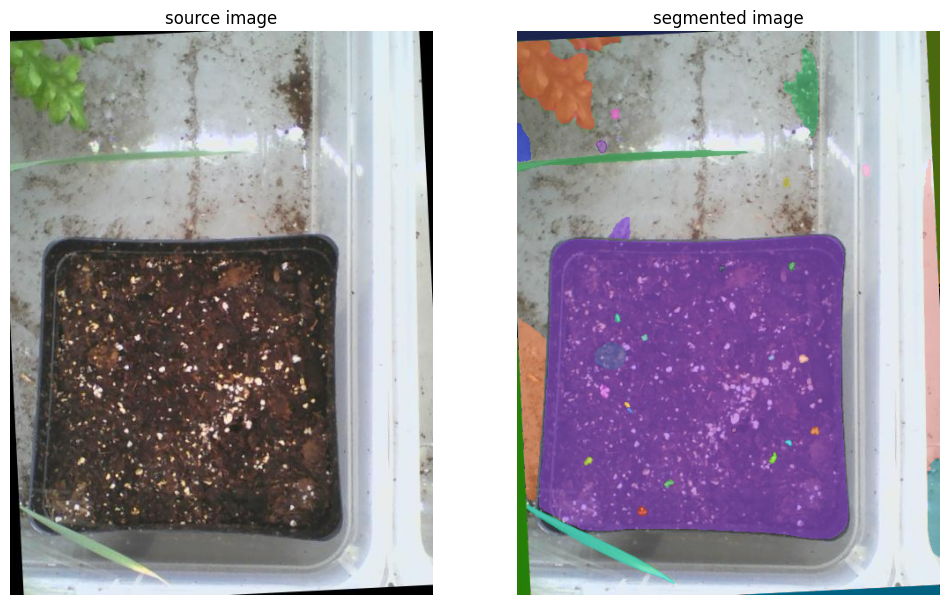

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

Centroid of the largest segmented area (pot): (403.1681766142918, 203.22921455679656)


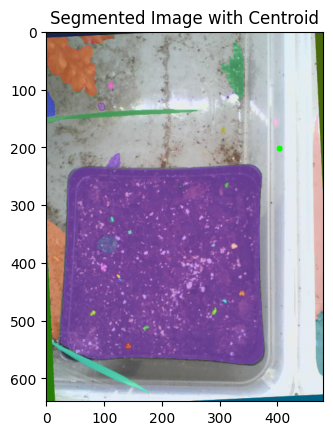

In [ ]:
# Sort masks by area in descending order and get the largest mask
largest_mask = max(sam_result, key=lambda x: x['area'])['segmentation']

# Compute the centroid of the largest mask
centroid = center_of_mass(largest_mask)

# Display the centroid coordinates
print(f"Centroid of the largest segmented area (pot): {centroid}")

# Draw the centroid on the image
centroid_coords = tuple(map(int, centroid))
cv2.circle(annotated_image, centroid_coords, 5, (0, 255, 0), -1)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title("Segmented Image with Centroid")
plt.show()

In [ ]:
# Calculate the FarmBot coordinates of the pot
image_width, image_height = image_rgb.shape[1], image_rgb.shape[0]
pot_x = image_x + (centroid[1] - image_width / 2)
pot_y = image_y + (centroid[0] - image_height / 2)
pot_z = image_z  # Assuming the z-coordinate remains the same

print(f"Pot coordinates on FarmBot: (x: {pot_x}, y: {pot_y}, z: {pot_z})")


Pot coordinates on FarmBot: (x: 1122.8292145567964, y: 612.9681766142917, z: -99.6)


### Interaction with segmentation results

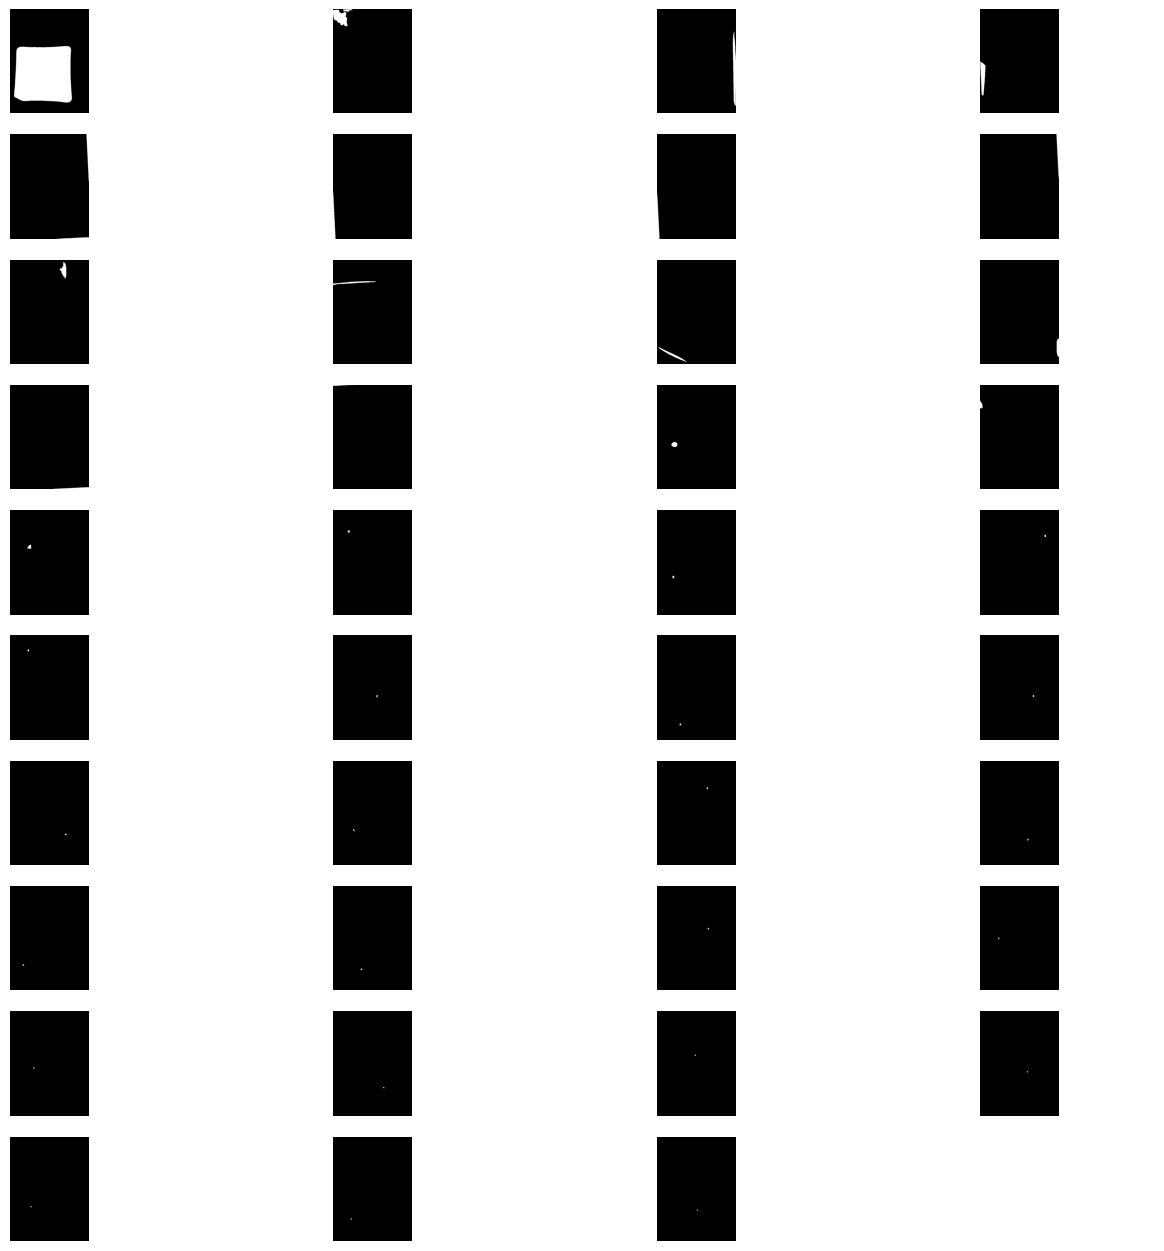

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(10, int(len(masks) / 8)),
    size=(16, 16)
)